In [1]:
import time

import numpy as np


def measure_smallest_delta():
    """
    Measures the smallest time interval between consecutive calls of time

    Returns:
        tuple: (start_time, end_time, delta_time)
    """
    #start_time = time.monotonic()
    start_time = time.perf_counter()
    end_time = start_time
    while end_time == start_time:
        #end_time = time.monotonic()
        end_time = time.perf_counter()
    delta_time = end_time - start_time
    return start_time, end_time, delta_time

def estimate_precision(num_samples):
    """
    Estimates the precision of the system clock by averaging the smallest time intervals.
    Args:
        num_samples: Number of samples to collect.
    """
    smallest_deltas = [measure_smallest_delta()[2] for _ in range(num_samples)]
    average_precision = np.average(smallest_deltas)
    return average_precision

# System timing settings
TIMER_RESOLUTION_SAMPLES = 1000
RELATIVE_ERROR_MEASURE = 0.01

resolution = estimate_precision(TIMER_RESOLUTION_SAMPLES)
min_duration = resolution * ((1.0 / RELATIVE_ERROR_MEASURE) + 1.0)

print(f"Precision of clock: {resolution:.8f}")

print(f"With a relative error of {RELATIVE_ERROR_MEASURE:.2f}, need to measure at least a time of {min_duration:.8f} seconds.")

import time
import tracemalloc
import numpy as np


def check_time_taken(graph, algorithm, heuristic, start, target, avg_samples, min_duration):
    """
    Measure the time and memory taken for multiple runs of a given algorithm on a graph and return aggregated results.

    Args:
        graph: The graph on which the operation is performed.
        algorithm: The algorithm/function to measure the time for.
        start: Starting node or parameter for the operation.
        target: Target node or parameter for the operation.
        avg_samples: Number of samples to collect for calculating mean and std.
        min_duration: Min duration for each time measurement.

    Returns:
        Tuple[float, float, float, float, float, float, float]: Aggregated results including average count of repetitions,
        average duration, median duration, standard deviation, average memory used, median memory used, and std memory used.
    """

    results = []

    # Checks time and memory taken multiple times
    for _ in range(avg_samples):
        start_time, end_time, count, duration, memory_used = check_time_taken_single_run(graph, algorithm, heuristic, start, target, min_duration)
        results.append((start_time, end_time, count, duration, memory_used))

    # Extract relevant information for aggregation
    durations = [item[3] for item in results]
    memories = [item[4] for item in results]

    # Calculate aggregated values
    avg_duration = sum(durations) / len(durations)
    median_duration = sorted(durations)[len(durations) // 2]
    std_duration = np.std(durations)

    avg_memory_used = sum(memories) / len(memories)
    median_memory_used = sorted(memories)[len(memories) // 2]
    std_memory_used = np.std(memories)

    # Return the aggregated results as a tuple
    return avg_duration, median_duration, std_duration, avg_memory_used, median_memory_used, std_memory_used


def check_time_taken_single_run(graph, algorithm, heuristic, start, target, min_duration):
    """
    Measure the time taken for a single run of a given algorithm on a graph.

    Args:
        graph: The graph on which the operation is performed.
        algorithm: The algorithm/function to measure the time for.
        start: Starting node or parameter for the operation.
        target: Target node or parameter for the operation.

    Returns:
        Tuple[float, float, int, float]: Start time, End time, Count of repetitions, Duration of the operation.
    """
    tracemalloc.start()
    count = 0  # Counter for the number of repetition
    start_time = end_time = 0.0 # Initialize start and end time
    start_time = time.perf_counter()
    while end_time - start_time <= min_duration: # Loop until we get to the min duration
        algorithm(graph, start, target, heuristic) # Execute the algorithm
        end_time = time.perf_counter()
        count += 1 # Keep a counter to know how many loops we performed
    current, peak = tracemalloc.get_traced_memory()
    #print(f"Current memory: {current}, Peak memory: {peak}")
    tracemalloc.clear_traces()
    # Return the results as a tuple
    # save peak if you are concerned about the maximum memory footprint of your code
    # save current if you are interested in the memory usage at a specific moment,
    return (start_time, end_time, count, end_time - start_time, peak)

Precision of clock: 0.00000011
With a relative error of 0.01, need to measure at least a time of 0.00001082 seconds.


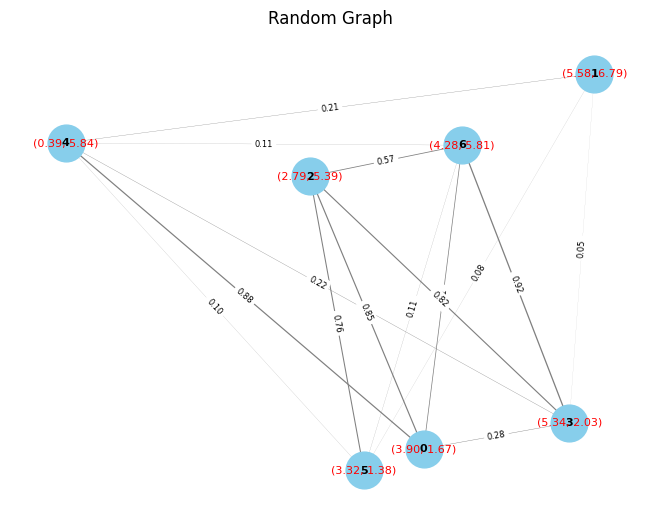

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Global variables for weight range
min_weight = 0.01
max_weight = 1.0
decimal_places = 3
SEED = 123

def generate_random_graph(nodes, edges, seed=SEED):
    max_edges = (nodes * (nodes - 1)) // 2
    if edges > max_edges:
        print(f"WARNING: Random graph - Number of edges ({edges}) exceeds the maximum possible for a random graph ({max_edges}).")
    edges = min(edges, max_edges)

    G_gnm = nx.gnm_random_graph(nodes, edges, seed)

    # Avoid self-loops
    G_gnm.remove_edges_from(nx.selfloop_edges(G_gnm))

    # Assign random weights to edges
    for edge in G_gnm.edges():
        G_gnm[edge[0]][edge[1]]['weight'] = np.random.uniform(min_weight, max_weight)

    # Assign random 2D coordinates to nodes
    for node in G_gnm.nodes():
        G_gnm.nodes[node]['coord2d'] = (np.random.uniform(0., nodes), np.random.uniform(0., nodes))

    return G_gnm


def plot_graph_topology(graph):
    pos = nx.get_node_attributes(graph, 'coord2d')
    weights = [graph[u][v]['weight'] for u, v in graph.edges()]

    nx.draw(graph, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_color='black', font_size=8, width=weights, edge_color='gray')

    for node, (x, y) in pos.items():
        plt.text(x, y, f'({x:.2f}, {y:.2f})', fontsize=8, ha='center', va='center', color='red')

    edge_labels = {(u, v): f'{graph[u][v]["weight"]:.2f}' for u, v in graph.edges()}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=6)

    plt.title("Random Graph")
    plt.show()

# Example usage:
nodes = 7
edges = 15
seed = 99

random_graph = generate_random_graph(nodes, edges, seed)
plot_graph_topology(random_graph)

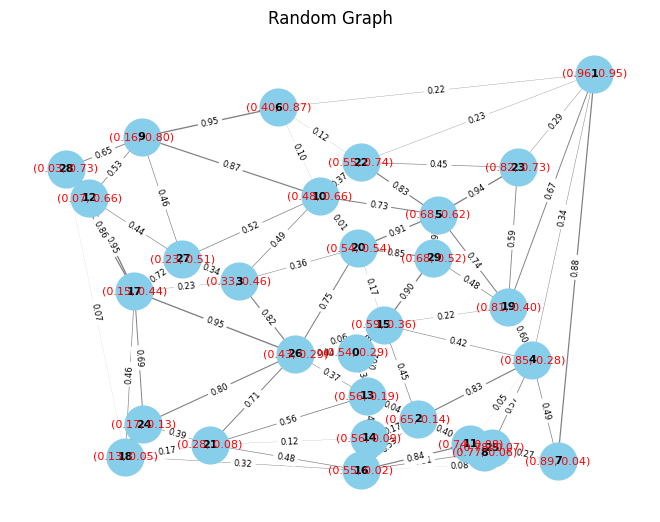

In [3]:
import networkx as nx
import numpy as np
from scipy.spatial import Delaunay

def generate_delaunay_graph(nodes, seed=SEED):
    points = np.random.rand(nodes, 2)  # Generate random 2D points

    tri = Delaunay(points)

    edges = []
    for simplex in tri.simplices:
        edges.extend([(simplex[i], simplex[j]) for i in range(3) for j in range(i+1, 3)])

    G_delaunay = nx.Graph(edges)

    # Assign random weights to edges
    for edge in G_delaunay.edges():
        G_delaunay[edge[0]][edge[1]]['weight'] = np.random.uniform(min_weight, max_weight)

    # Assign Delaunay coordinates to nodes
    for node, coords in enumerate(points):
        G_delaunay.nodes[node]['coord2d'] = tuple(coords)

    return G_delaunay

# Example usage
nodes = 30
G_delaunay = generate_delaunay_graph(nodes)
plot_graph_topology(G_delaunay)

100%|██████████| 100/100 [00:00<00:00, 6074.12it/s]

Average Path Length: 4.68
Standard Deviation of Path Length: 2.11


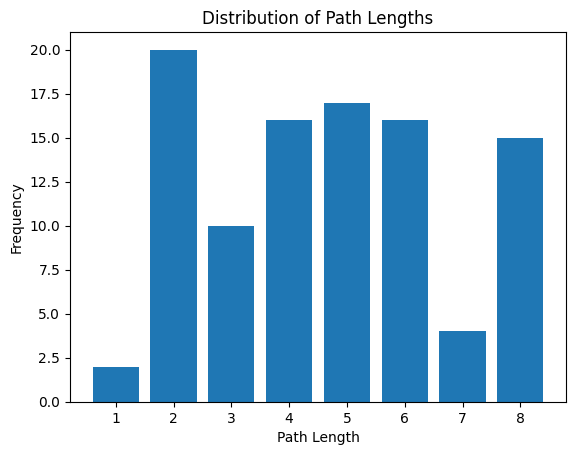

In [4]:
def generate_instance(num_nodes, min_edges_factor=0.5, max_edges_factor=1.0):
    if num_nodes <= 0:
        raise ValueError("Number of nodes must be greater than 0.")

    min_edges = int(min_edges_factor * num_nodes)
    max_edges = int(max_edges_factor * (num_nodes * (num_nodes - 1)) // 2)

    if min_edges >= max_edges:
        max_edges = min_edges + 1

    num_edges = np.random.randint(min_edges, max_edges)

    random_graph = generate_random_graph(num_nodes, num_edges)

    return random_graph

import networkx as nx
import random
from tqdm import tqdm

def random_start_and_target(graph, max_trials=100):
    # Get a list of all nodes in the graph
    nodes_list = list(graph.nodes())

    # Ensure that the graph is not empty
    if not nodes_list:
        raise ValueError("Graph is empty, cannot choose nodes.")
    
    tries = 0
    while tries <= max_trials:
        # Randomly select a starting node
        start_node = random.choice(nodes_list)

        # Randomly select a target node
        target_node = random.choice(nodes_list)

        # Check if the target node is reachable from the starting node
        if nx.has_path(graph, start_node, target_node):
            return start_node, target_node
    
    return None, None

def repeat_and_plot(n_instances, max_num_nodes):
    path_lengths = []

    for _ in tqdm(range(n_instances)):
        graph = generate_instance(np.random.randint(3, max_num_nodes))
        start, target = random_start_and_target(graph)

        if start is None:
            continue
        
        # Compute the path using DFS edges
        path = list(nx.dfs_edges(graph, start, target))
        path_length = len(path) + 1  # Adding 1 for the target node

        path_lengths.append(path_length)
    
    # Calculate average and standard deviation
    average_path_length = np.mean(path_lengths)
    std_dev_path_length = np.std(path_lengths)

    # Print the results
    print(f"Average Path Length: {average_path_length:.2f}")
    print(f"Standard Deviation of Path Length: {std_dev_path_length:.2f}")

    # Plotting
    plt.hist(path_lengths, bins=range(min(path_lengths), max(path_lengths) + 1), align='left', rwidth=0.8)
    plt.title('Distribution of Path Lengths')
    plt.xlabel('Path Length')
    plt.ylabel('Frequency')
    plt.show()

# Example usage:
repeat_and_plot(100, 10)


100%|██████████| 100/100 [00:00<00:00, 1535.84it/s]

Average Path Length: 5.27
Standard Deviation of Path Length: 1.90


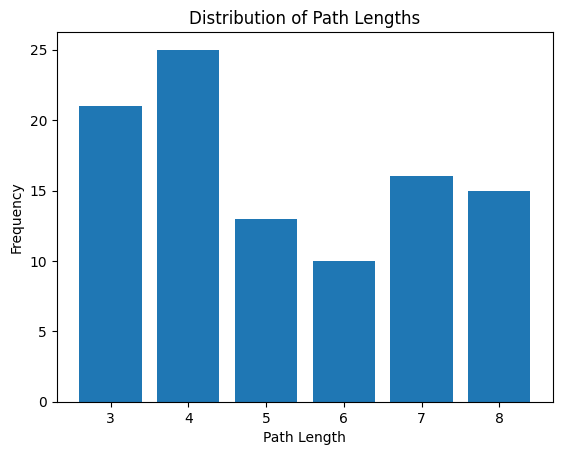

In [5]:
def generate_instance(num_nodes):
    if num_nodes <= 0:
        raise ValueError("Number of nodes must be greater than 0.")
    random_graph = generate_delaunay_graph(num_nodes)

    return random_graph

import networkx as nx
import random
from tqdm import tqdm

def random_start_and_target(graph, max_trials=100):
    # Get a list of all nodes in the graph
    nodes_list = list(graph.nodes())

    # Ensure that the graph is not empty
    if not nodes_list:
        raise ValueError("Graph is empty, cannot choose nodes.")
    
    tries = 0
    while tries <= max_trials:
        # Randomly select a starting node
        start_node = random.choice(nodes_list)

        # Randomly select a target node
        target_node = random.choice(nodes_list)

        # Check if the target node is reachable from the starting node
        if nx.has_path(graph, start_node, target_node):
            return start_node, target_node
    
    return None, None

# Example usage:
repeat_and_plot(100, 10)


In [6]:
def calculate_trials(num_nodes):
    # Adjust the constant as needed
    constant = 1500
    trials = max(1, int(constant / num_nodes))
    return trials


In [7]:
import heapq
from collections import deque
import math

def manhattan_distance(graph, node, target):
    x1, y1 = graph.nodes[node]['coord2d']
    x2, y2 = graph.nodes[target]['coord2d']
    return abs(x1 - x2) + abs(y1 - y2)

def euclidean_distance(graph, node, target):
    x1, y1 = graph.nodes[node]['coord2d']
    x2, y2 = graph.nodes[target]['coord2d']
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def chebyshev_distance(graph, node, target):
    x1, y1 = graph.nodes[node]['coord2d']
    x2, y2 = graph.nodes[target]['coord2d']
    return max(abs(x1 - x2), abs(y1 - y2))

def minkowski_distance(graph, node, target, p=3): # 3rd deg
    x1, y1 = graph.nodes[node]['coord2d']
    x2, y2 = graph.nodes[target]['coord2d']
    return ((abs(x1 - x2)**p + abs(y1 - y2)**p)**(1/p))

def diagonal_manhattan_distance(graph, node, target):
    x1, y1 = graph.nodes[node]['coord2d']
    x2, y2 = graph.nodes[target]['coord2d']
    dx = abs(x1 - x2)
    dy = abs(y1 - y2)
    return max(dx, dy) + (np.sqrt(2) - 1) * min(dx, dy)

def best_first_search_multi_heuristics(graph, start, target, heuristic):
    open_set = [(heuristic(graph, start, target), start, [])]
    visited = set()

    while open_set:
        _, current, path = heapq.heappop(open_set)

        if current == target:
            return path + [current]

        if current not in visited:
            visited.add(current)

            for neighbor in graph.neighbors(current):
                if neighbor not in visited:
                    new_path = path + [current]
                    priority = heuristic(graph, neighbor, target)
                    heapq.heappush(open_set, (priority, neighbor, new_path))

    return None  # No path found

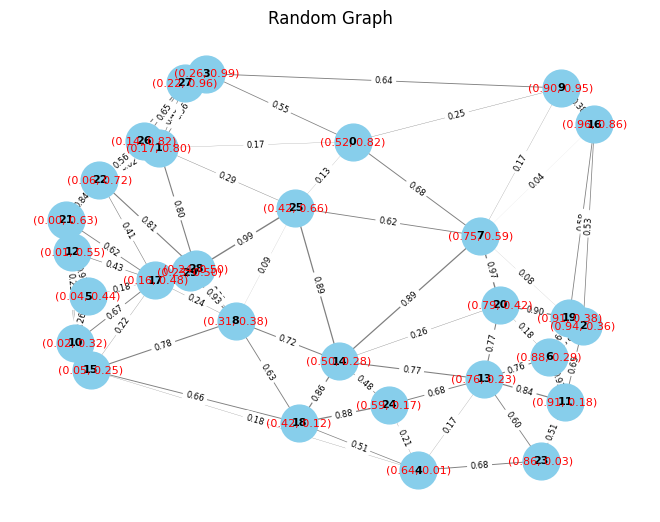

Path using Manhattan distance: [0, 7, 14, 24, 4]
Path using Euclidean distance: [0, 7, 14, 24, 4]
Path using Chebyshev distance: [0, 7, 14, 24, 4]
Path using Minkowski distance: [0, 7, 14, 24, 4]
Path using Diagonal Manhattan distance: [0, 7, 14, 24, 4]
Average time taken by Manhattan distance: 8.955999999216147e-05
Average time taken by Euclidean distance: 0.00015270999992935685
Average time taken by Chebyshev distance: 9.17900000104055e-05
Average time taken by Minkowski distance: 0.00012014999997518316
Average time taken by Diagonal Manhattan distance: 0.00021781999998893298


In [8]:
import networkx as nx
import numpy as np

# Create a small graph
random_graph = generate_delaunay_graph(nodes)
plot_graph_topology(random_graph)

# Example: Using Manhattan distance
start_node = 0
target_node = 4

# Run the search algorithm with Manhattan distance
path_manhattan = best_first_search_multi_heuristics(random_graph, start_node, target_node, manhattan_distance)
print("Path using Manhattan distance:", path_manhattan)

# Example: Using Euclidean distance
# Run the search algorithm with Euclidean distance
path_euclidean = best_first_search_multi_heuristics(random_graph, start_node, target_node, euclidean_distance)
print("Path using Euclidean distance:", path_euclidean)

# Example: Using Chebyshev distance
# Run the search algorithm with Chebyshev distance
path_chebyshev = best_first_search_multi_heuristics(random_graph, start_node, target_node, chebyshev_distance)
print("Path using Chebyshev distance:", path_chebyshev)

# Example: Using Minkowski distance (3rd degree)
# Run the search algorithm with Minkowski distance
path_minkowski = best_first_search_multi_heuristics(random_graph, start_node, target_node, minkowski_distance)
print("Path using Minkowski distance:", path_minkowski)

# Example: Using Diagonal Manhattan distance
# Run the search algorithm with Diagonal Manhattan distance
path_diagonal_manhattan = best_first_search_multi_heuristics(random_graph, start_node, target_node, diagonal_manhattan_distance)
print("Path using Diagonal Manhattan distance:", path_diagonal_manhattan)

manhattan_time = check_time_taken(random_graph, best_first_search_multi_heuristics, manhattan_distance, start_node, target_node, avg_samples=10, min_duration=min_duration)
euclidean_time = check_time_taken(random_graph, best_first_search_multi_heuristics, euclidean_distance, start_node, target_node, avg_samples=10, min_duration=min_duration)
chebyshev_time = check_time_taken(random_graph, best_first_search_multi_heuristics, chebyshev_distance, start_node, target_node, avg_samples=10, min_duration=min_duration)
minkowski_time = check_time_taken(random_graph, best_first_search_multi_heuristics, minkowski_distance, start_node, target_node, avg_samples=10, min_duration=min_duration)
diagonal_manhattan_time = check_time_taken(random_graph, best_first_search_multi_heuristics, diagonal_manhattan_distance, start_node, target_node, avg_samples=10, min_duration=min_duration)

print("Average time taken by Manhattan distance:", manhattan_time[0])
print("Average time taken by Euclidean distance:", euclidean_time[0])
print("Average time taken by Chebyshev distance:", chebyshev_time[0])
print("Average time taken by Minkowski distance:", minkowski_time[0])
print("Average time taken by Diagonal Manhattan distance:", diagonal_manhattan_time[0])

In [9]:
# Function to generate random instances and get the best heuristic for each
def generate_and_check_distribution(N, nodes, trials):
    heuristic_functions = [manhattan_distance, euclidean_distance, chebyshev_distance, minkowski_distance, diagonal_manhattan_distance]
    total_counts = {heuristic.__name__: 0 for heuristic in heuristic_functions}

    for _ in tqdm(range(N)):
        graph = generate_delaunay_graph(nodes, seed)
        for _ in range(trials):
            start_node, target_node = random_start_and_target(graph)
            best_heuristic = None
            best_path_length = float('inf')

            for heuristic in heuristic_functions:
                path = best_first_search_multi_heuristics(graph, start_node, target_node, heuristic)
                if path and len(path) < best_path_length:
                    best_path_length = len(path)
                    best_heuristic = heuristic.__name__

            total_counts[best_heuristic] += 1

    return total_counts


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


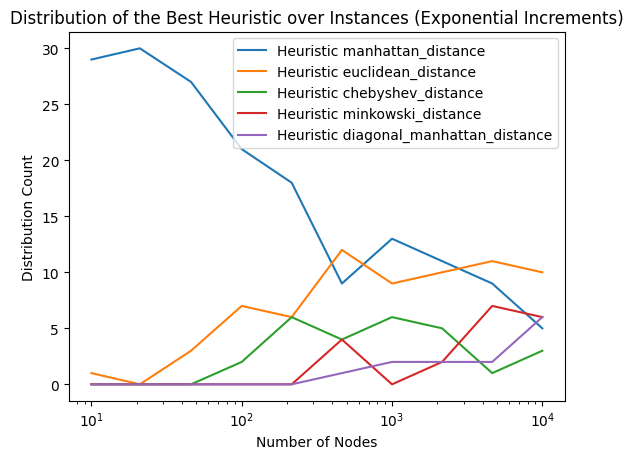

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# List of heuristic functions
heuristics = ['manhattan_distance', 'euclidean_distance', 'chebyshev_distance', 'minkowski_distance', 'diagonal_manhattan_distance']
counts_per_heuristic = {heuristic: [] for heuristic in heuristics}

# Set your parameters
N = 10  # Number of instances to generate
max_num_nodes = 10000
seed = 112233  # Random seed for reproducibility
trials = 3  # Number of trials for each instance

# Create an array of exponentially increasing node values
nodes_values = np.logspace(1, np.log10(max_num_nodes), num=10, dtype=int)

for nodes in tqdm(nodes_values):
    distribution_counts = generate_and_check_distribution(N, nodes, trials)

    # Append data for plotting
    heuristics.append(nodes)
    for heuristic, count in distribution_counts.items():
        counts_per_heuristic[heuristic].append(count)

# Plotting
fig, ax = plt.subplots()

for heuristic, counts in counts_per_heuristic.items():
    ax.plot(nodes_values, counts, label=f"Heuristic {heuristic}")

ax.set_xscale('log')  # Set x-axis to a logarithmic scale
ax.set_xlabel('Number of Nodes')
ax.set_ylabel('Distribution Count')
ax.set_title('Distribution of the Best Heuristic over Instances (Exponential Increments)')
ax.legend()
plt.show()


In [12]:
start = time.time()
distribution_counts = generate_and_check_distribution(1, 50, 60)
print("taken:")
print(time.time() - start)

100%|██████████| 1/1 [00:00<00:00, 18.47it/s]

taken:
0.059172630310058594


### GENERATE INSTANCES

In [13]:
num_graphs = 50000
min_nodes = 500
max_nodes = 50000

list_of_possible_nodes = list(range(min_nodes, max_nodes + 1))
len(list_of_possible_nodes)

49501

In [14]:
import socket
computer_name = socket.gethostname()

In [15]:
import datetime
import pickle
import numpy as np
from tqdm import tqdm
import networkx as nx



# Parameters
num_graphs = 50000
min_nodes = 500
max_nodes = 50000

seed = 112233445566778899

interval_save = 10000  # Set the interval for saving

graphs = []

# Include max_nodes in the range
list_of_possible_nodes = list(range(min_nodes, max_nodes + 1))

# Generate the list of graphs with random node counts
list_of_possible_nodes = list(np.random.choice(
    list_of_possible_nodes, num_graphs, replace=True))

# Create and save the dataset
dataset = []

for i in tqdm(range(num_graphs)):
    # Generate a graph instance
    num_nodes = np.random.choice(list_of_possible_nodes)
    list_of_possible_nodes.remove(num_nodes)

    graph = generate_delaunay_graph(num_nodes, seed)
    graphs.append(graph)

    # Save graphs at regular intervals
    if (i + 1) % interval_save == 0 or (i + 1) == num_graphs:
        file_name = f"graphs_{computer_name}_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}_{i + 1}.pkl"
        with open(file_name, 'wb') as file:
            pickle.dump(graphs, file)
        print(f"Graphs saved to {file_name}")

print(f"Graphs saved to {file_name}")


  0%|          | 87/50000 [02:45<24:12:46,  1.75s/it]

In [ ]:
import networkx as nx
import statistics
import math
import numpy as np
import pandas as pd
import time

def compute_all_metrics(graph):

    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()

    # Calculate graph size features
    ratio_n_m = num_nodes / num_edges if num_edges != 0 else 0
    ratio_m_n = num_edges / num_nodes if num_nodes != 0 else 0

    # Calculate node degree statistics
    degrees = list(dict(graph.degree()).values())
    degrees_np = np.array(degrees)

    min_degree = np.min(degrees_np)
    max_degree = np.max(degrees_np)
    mean_degree = np.mean(degrees_np)
    median_degree = np.median(degrees_np)
    q0_25_degree, q0_75_degree = np.percentile(degrees_np, [25, 75])
    variation_coefficient_degree = np.std(degrees_np) / mean_degree
    entropy_term = np.fromiter(
        (p * np.log2(p) for p in (np.count_nonzero(degrees_np == x) / len(degrees_np) for x in set(degrees_np))),
        dtype=float
    )
    entropy_degree = -np.sum(entropy_term)

    # Calculate maximal clique statistics
    cliques = list(map(len, nx.enumerate_all_cliques(graph)))
    cliques_np = np.array(cliques)

    normalized_min_clique_size = np.min(cliques_np) / num_nodes if num_nodes > 0 else 0
    normalized_max_clique_size = np.max(cliques_np) / num_nodes if num_nodes > 0 else 0
    normalized_median_clique_size = statistics.median(cliques) / num_nodes if num_nodes > 0 else 0
    normalized_q0_25_clique_size, normalized_q0_75_clique_size = np.percentile(cliques_np, [25, 75]) / num_nodes if num_nodes > 0 else (0, 0)
    normalized_variation_coefficient_clique_size = np.std(cliques_np) / statistics.mean(cliques) if len(
        cliques) > 1 else 0
    normalized_entropy_clique_size = -sum(
        p * math.log2(p) for p in (np.count_nonzero(cliques_np == x) / len(cliques_np) for x in set(cliques_np))) / num_nodes if num_nodes > 0 else 0

    # NetworkX metrics
    is_graph_connected = nx.is_connected(graph)

    degree_centrality_values = nx.degree_centrality(graph)
    average_degree_centrality = np.mean(list(degree_centrality_values.values()))

    betweenness_centrality_values = nx.betweenness_centrality(graph)
    average_betweenness_centrality = np.mean(list(betweenness_centrality_values.values()))

    closeness_centrality_values = nx.closeness_centrality(graph)
    average_closeness_centrality = np.mean(list(closeness_centrality_values.values()))

    average_clustering_coefficient = nx.average_clustering(graph)

    pagerank_values = nx.pagerank(graph)
    average_pagerank = np.mean(list(pagerank_values.values()))

    eigenvector_centrality_values = nx.eigenvector_centrality(graph, max_iter=1000)
    average_eigenvector_centrality = np.mean(list(eigenvector_centrality_values.values()))

    graph_density = nx.density(graph)

    diameter_value = nx.diameter(graph) if is_graph_connected else 0

    average_path_length_value = nx.average_shortest_path_length(graph) if is_graph_connected else 0
    
    edge_connectivity_value = nx.edge_connectivity(graph) if is_graph_connected else 0

    node_connectivity_value = nx.node_connectivity(graph) if is_graph_connected else 0

    transitivity_value = nx.transitivity(graph)

    assortativity_coefficient = nx.degree_assortativity_coefficient(graph)

    global_efficiency = nx.global_efficiency(graph)

    # Store metrics in a dictionary
    metrics_dict = {
        "num_nodes": num_nodes,
        "num_edges": num_edges,
        "ratio_n_m": ratio_n_m,
        "ratio_m_n": ratio_m_n,
        "density": graph_density,
        "min_degree": min_degree,
        "max_degree": max_degree,
        "mean_degree": mean_degree,
        "median_degree": median_degree,
        "q0_25_degree": q0_25_degree,
        "q0_75_degree": q0_75_degree,
        "variation_coefficient_degree": variation_coefficient_degree,
        "entropy_degree": entropy_degree,
        "normalized_min_clique_size": normalized_min_clique_size,
        "normalized_max_clique_size": normalized_max_clique_size,
        "normalized_median_clique_size": normalized_median_clique_size,
        "normalized_q0_25_clique_size": normalized_q0_25_clique_size,
        "normalized_q0_75_clique_size": normalized_q0_75_clique_size,
        "normalized_variation_coefficient_clique_size": normalized_variation_coefficient_clique_size,
        "normalized_entropy_clique_size": normalized_entropy_clique_size,
        "average_degree_centrality": average_degree_centrality,
        "average_betweenness_centrality": average_betweenness_centrality,
        "average_closeness_centrality": average_closeness_centrality,
        "average_clustering_coefficient": average_clustering_coefficient,
        "average_pagerank": average_pagerank,
        "average_eigenvector_centrality": average_eigenvector_centrality,
        "graph_density": graph_density,
        "diameter_value": diameter_value,
        "average_path_length_value": average_path_length_value,
        "edge_connectivity_value": edge_connectivity_value,
        "node_connectivity_value": node_connectivity_value,
        "transitivity_value": transitivity_value,
        "assortativity_coefficient": assortativity_coefficient,
        "global_efficiency": global_efficiency
    }

    return metrics_dict

,num_nodes,num_edges,ratio_n_m,ratio_m_n,density,min_degree,max_degree,mean_degree,median_degree,q0_25_degree,...,average_pagerank,average_eigenvector_centrality,graph_density,diameter_value,average_path_length_value,edge_connectivity_value,node_connectivity_value,transitivity_value,assortativity_coefficient,global_efficiency
0,10.0,21.0,0.47619,2.1,0.466667,3.0,6.0,4.2,4.0,4.0,...,0.1,0.309775,0.466667,3.0,1.622222,3.0,3.0,0.507042,-0.061798,0.718519


In [ ]:
import glob
import os
import pickle
import datetime
import csv
from tqdm import tqdm
import numpy as np

# Specify the directory containing your .pkl files
directory_path = "."

# Find all .pkl files in the current directory
pkl_files = glob.glob(os.path.join(directory_path, '*.pkl'))

# Create a CSV file for storing metrics
csv_file_name = f"metrics_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}.csv"

# Specify the metrics keys
metrics_keys = [
    "num_nodes", "num_edges", "ratio_n_m", "ratio_m_n", "density", "min_degree", "max_degree",
    "mean_degree", "median_degree", "q0_25_degree", "q0_75_degree", "variation_coefficient_degree",
    "entropy_degree", "normalized_min_clique_size", "normalized_max_clique_size",
    "normalized_median_clique_size", "normalized_q0_25_clique_size", "normalized_q0_75_clique_size",
    "normalized_variation_coefficient_clique_size", "normalized_entropy_clique_size",
    "average_degree_centrality", "average_betweenness_centrality", "average_closeness_centrality",
    "average_clustering_coefficient", "average_pagerank", "average_eigenvector_centrality",
    "graph_density", "diameter_value", "average_path_length_value", "edge_connectivity_value",
    "node_connectivity_value", "transitivity_value", "assortativity_coefficient", "global_efficiency"
]

heuristic_functions = [manhattan_distance, euclidean_distance, chebyshev_distance, minkowski_distance, diagonal_manhattan_distance]


with open(csv_file_name, 'w', newline='') as csv_file:
    csv_writer = csv.DictWriter(csv_file, fieldnames=["graph_idx", "best_heuristic"] + metrics_keys)
    csv_writer.writeheader()

    # Iterate over each .pkl file
    for file_name in pkl_files:
        with open(file_name, 'rb') as file:
            graphs = pickle.load(file)

        # Iterate over each graph
        for i, graph in enumerate(tqdm(graphs)):
            start_node, target_node = random_start_and_target(graph)
            best_heuristic = None
            best_path_length = float('inf')
            best_metrics = None

            # Check metrics for each heuristic
            for heuristic in heuristic_functions:
                path = best_first_search_multi_heuristics(graph, start_node, target_node, heuristic)
                if path and len(path) < best_path_length:
                    best_path_length = len(path)
                    best_heuristic = heuristic.__name__
                    best_metrics = compute_all_metrics(graph)

            # Append metrics to the CSV file
            csv_writer.writerow({"graph_idx": i, "best_heuristic": best_heuristic, **best_metrics})

print(f"Metrics saved to {csv_file_name}")

100%|██████████| 1000/1000 [06:22<00:00,  2.61it/s]

Metrics saved to metrics_20231220234115.csv


In [22]:
import pandas as pd
import glob

# Specify the directory containing your CSV files
directory_path = "."

# Find the most recent CSV file based on the filename pattern
latest_csv_file = max(glob.glob(os.path.join(directory_path, 'metrics_*.csv')), key=os.path.getctime)

# Load the CSV file into a DataFrame
df = pd.read_csv(latest_csv_file)

# Display the DataFrame
df


,graph_idx,best_heuristic,num_nodes,num_edges,ratio_n_m,ratio_m_n,density,min_degree,max_degree,mean_degree,...,average_closeness_centrality,average_clustering_coefficient,average_pagerank,average_eigenvector_centrality,graph_density,diameter_value,average_path_length_value,edge_connectivity_value,node_connectivity_value,transitivity_value
0,0,manhattan_distance,65,181,0.359116,2.784615,0.087019,3,10,5.569231,...,0.289924,0.469707,0.015385,0.116064,0.087019,7,3.486058,3,3,0.399329
1,1,manhattan_distance,74,209,0.354067,2.824324,0.077379,3,9,5.648649,...,0.270716,0.458430,0.013514,0.109836,0.077379,8,3.722325,3,3,0.396336
2,2,manhattan_distance,62,172,0.360465,2.774194,0.090957,3,9,5.548387,...,0.291332,0.454954,0.016129,0.120848,0.090957,7,3.461660,3,3,0.399760
3,3,manhattan_distance,12,27,0.444444,2.250000,0.409091,3,7,4.500000,...,0.591501,0.536111,0.083333,0.280568,0.409091,3,1.712121,3,3,0.470588
4,4,manhattan_distance,70,194,0.360825,2.771429,0.080331,3,9,5.542857,...,0.269334,0.473277,0.014286,0.111590,0.080331,7,3.745756,3,3,0.400631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,manhattan_distance,86,243,0.353909,2.825581,0.066484,3,9,5.651163,...,0.251011,0.455565,0.011628,0.099033,0.066484,8,4.018331,3,3,0.397500
996,996,manhattan_distance,81,227,0.356828,2.802469,0.070062,4,9,5.604938,...,0.251708,0.448295,0.012346,0.103175,0.070062,8,4.012654,4,4,0.399819
997,997,manhattan_distance,74,205,0.360976,2.770270,0.075898,3,8,5.540541,...,0.256998,0.469562,0.013514,0.108589,0.075898,8,3.935579,3,3,0.408678
998,998,manhattan_distance,38,101,0.376238,2.657895,0.143670,3,8,5.315789,...,0.349231,0.458396,0.026316,0.155327,0.143670,6,2.887624,3,3,0.418301


         best_heuristic best_heuristic_mapped
0    manhattan_distance             Manhattan
1    manhattan_distance             Manhattan
2    manhattan_distance             Manhattan
3    manhattan_distance             Manhattan
4    manhattan_distance             Manhattan
..                  ...                   ...
995  manhattan_distance             Manhattan
996  manhattan_distance             Manhattan
997  manhattan_distance             Manhattan
998  manhattan_distance             Manhattan
999  euclidean_distance             Euclidean

[1000 rows x 2 columns]


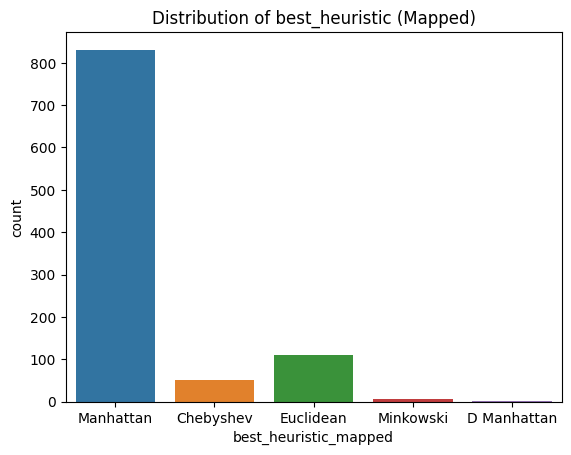

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt


# Map the best heuristics
heuristic_mapping = {
    'manhattan_distance': 'Manhattan',
    'euclidean_distance': 'Euclidean',
    'chebyshev_distance': 'Chebyshev',
    'minkowski_distance': 'Minkowski',
    'diagonal_manhattan_distance': 'D Manhattan',
    # Add more mappings as needed
}

# Replace values in the 'best_heuristic' column
df['best_heuristic_mapped'] = df['best_heuristic'].map(heuristic_mapping)

# Display the updated DataFrame with the mapped values
print(df[['best_heuristic', 'best_heuristic_mapped']])

# Plot the updated distribution
sns.countplot(x='best_heuristic_mapped', data=df)
plt.title('Distribution of best_heuristic (Mapped)')
plt.show()

In [ ]:
# Check with PCA